In [1]:
from fastai.collab import *
from fastai.tabular.all import *
from time import *

In [2]:
path = Path('.')
path.ls()

(#8) [Path('.git'),Path('SolarEnergyDataRefine.ipynb'),Path('SolarEnergy.zip'),Path('weather_in_Antwerp_future2.csv'),Path('Weather.zip'),Path('PV_Elec_Gas3.csv'),Path('.ipynb_checkpoints'),Path('weather_in_Antwerp.csv')]

Source: https://www.kaggle.com/ramima/weather-dataset-in-antwerp-belgium

In [3]:
weather = pd.read_csv(path/'weather_in_Antwerp.csv', delimiter=';', engine='python',
                     header=0)

In [4]:
weather.head()

,Unnamed: 0,clock,temp,weather,wind,humidity,barometer,visibility,year,month,day
0,0,00:20,11 °C,Mostly cloudy.,17 km/h,94%,1011 mbar,5 km,2012,1,1
1,1,00:50,12 °C,Mostly cloudy.,17 km/h,88%,1011 mbar,NaN,2012,1,1
2,2,01:50,12 °C,Overcast.,19 km/h,88%,1011 mbar,9 km,2012,1,1
3,3,02:20,12 °C,Partly cloudy.,17 km/h,88%,1010 mbar,NaN,2012,1,1
4,4,02:50,12 °C,Sprinkles. Mostly cloudy.,15 km/h,88%,1010 mbar,NaN,2012,1,1


One or some parameters (barometer for example) may not have effect on the amount of generated solar energy. However, in a linear regression model, this is not a big concern. Parameters that have small impact on the result simply have smaller coefficients.

As shown in the table above, some data is missing. Therefore, the dataset needs to be cleaned. There are two index columns in thae table, so let start by removing one of them.

In [5]:
weather.drop(labels='Unnamed: 0', axis=1, inplace=True)
weather.head()

,clock,temp,weather,wind,humidity,barometer,visibility,year,month,day
0,00:20,11 °C,Mostly cloudy.,17 km/h,94%,1011 mbar,5 km,2012,1,1
1,00:50,12 °C,Mostly cloudy.,17 km/h,88%,1011 mbar,NaN,2012,1,1
2,01:50,12 °C,Overcast.,19 km/h,88%,1011 mbar,9 km,2012,1,1
3,02:20,12 °C,Partly cloudy.,17 km/h,88%,1010 mbar,NaN,2012,1,1
4,02:50,12 °C,Sprinkles. Mostly cloudy.,15 km/h,88%,1010 mbar,NaN,2012,1,1


The inplace flag tell the function to replace the current table by the new table, in which the 'unnamed: 0' column was removed. Now let check if other columns contain unwanted data (NaN for example)

In [88]:
clock_ls = weather['clock'].tolist()
clock_ls = list(dict.fromkeys(clock_ls))
print(clock_ls)

['00:20', '00:50', '01:50', '02:20', '02:50', '03:20', '03:50', '04:20', '04:50', '05:20', '05:50', '06:20', '06:50', '07:20', '07:50', '08:50', '09:20', '09:50', '10:20', '10:50', '11:20', '11:50', '12:20', '12:50', '13:20', '13:50', '14:20', '14:50', '15:20', '15:50', '16:20', '16:50', '17:20', '17:50', '18:20', '18:50', '19:20', '19:50', '20:50', '21:20', '21:50', '22:20', '22:50', '23:20', '23:50', '01:20', '08:20', '20:20']


The list is first converted to a dictionary. Since a dictionary does not accept duplicate keys, all duplicated values are removed. At the end, we have a list of values in a column. This method can be applied to the rest of the table.

In [89]:
temp_ls = weather['temp'].tolist()
temp_ls = list(dict.fromkeys(temp_ls))
print(temp_ls)

['11\xa0°C', '12\xa0°C', '13\xa0°C', '14\xa0°C', '10\xa0°C', '9\xa0°C', '8\xa0°C', '7\xa0°C', '6\xa0°C', '5\xa0°C', '4\xa0°C', '3\xa0°C', '2\xa0°C', '1\xa0°C', '0\xa0°C', '-1\xa0°C', '-2\xa0°C', '-3\xa0°C', '-4\xa0°C', '-5\xa0°C', '-6\xa0°C', '-7\xa0°C', '-8\xa0°C', '-9\xa0°C', '-10\xa0°C', '-11\xa0°C', '-14\xa0°C', '-12\xa0°C', '-13\xa0°C', '-15\xa0°C', '15\xa0°C', '16\xa0°C', '17\xa0°C', '18\xa0°C', '19\xa0°C', '20\xa0°C', nan, '21\xa0°C', '22\xa0°C', '23\xa0°C', '24\xa0°C', '25\xa0°C', '26\xa0°C', '27\xa0°C', '28\xa0°C', '29\xa0°C', '30\xa0°C', '31\xa0°C', '32\xa0°C', '33\xa0°C', '34\xa0°C', '35\xa0°C', '36\xa0°C', '37\xa0°C', '38\xa0°C', '39\xa0°C', '40\xa0°C']


Does not look so beutiful. But at least we do not see any strange value. The unit (oC) can be removed from this list. However we later will use a different method to remove it from the data frame. There is no point to do it right now.

In [90]:
weather_ls = weather['weather'].tolist()
weather_ls = list(dict.fromkeys(weather_ls))
print(weather_ls)

['Mostly cloudy.', 'Overcast.', 'Partly cloudy.', 'Sprinkles. Mostly cloudy.', 'Sprinkles. Partly cloudy.', 'Sprinkles. Fog.', 'Light rain. Mostly cloudy.', 'Low clouds.', 'Fog.', 'Sprinkles. Overcast.', 'Sprinkles. More clouds than sun.', 'Cloudy.', 'Light rain. Overcast.', 'Light rain. More clouds than sun.', 'Light rain. Cloudy.', 'Light rain. Broken clouds.', 'Sprinkles. Passing clouds.', 'Light rain. Partly cloudy.', 'Hail. Partly cloudy.', 'Light rain. Passing clouds.', 'Passing clouds.', 'Scattered clouds.', 'Clear.', 'Partly sunny.', 'Light rain. Partly sunny.', 'Light rain. Fog.', 'Rain. Fog.', 'Rain. Passing clouds.', 'Broken clouds.', 'Heavy rain. Partly cloudy.', 'Rain showers. Broken clouds.', 'Rain showers. Partly cloudy.', 'More clouds than sun.', 'Sprinkles. Low clouds.', 'Sprinkles. Broken clouds.', 'Chilly.', 'Ice fog.', 'Light fog.', 'Sunny.', 'Cold.', 'Drizzle. Partly sunny.', 'Drizzle. Fog.', 'Rain showers. Passing clouds.', 'Light rain. Scattered clouds.', 'Drizzl

This column describes how the weather looked like. Each states ends with a dot '.' and at a moment there can be more than one weather state that suit.

In [92]:
wind_ls = weather['wind'].tolist()
wind_ls = list(dict.fromkeys(wind_ls))
print(wind_ls)

['17 km/h', '19 km/h', '15 km/h', '22 km/h', '24 km/h', '20 km/h', '26 km/h', '28 km/h', '33 km/h', '35 km/h', '32 km/h', '11 km/h', '13 km/h', '30 km/h', '44 km/h', '43 km/h', '39 km/h', '41 km/h', '46 km/h', '37 km/h', '54 km/h', '48 km/h', '9 km/h', '7 km/h', '4 km/h', '6 km/h', '2 km/h', 'No wind', nan, '50 km/h', '52 km/h', '57 km/h', '67 km/h', '65 km/h', '59 km/h']


Here we see two non-numerical values which are 'No wind' and 'nan'. We will have to replace these value with numerical values later.

In [93]:
humidity_ls = weather['humidity'].tolist()
humidity_ls = list(dict.fromkeys(humidity_ls))
print(humidity_ls)

['94%', '88%', '82%', '87%', '76%', '71%', '66%', '61%', '81%', '77%', '67%', '93%', '70%', '57%', '75%', '100%', '80%', '86%', '65%', '69%', '56%', '52%', '49%', '46%', '42%', '60%', nan, '62%', '74%', '79%', '73%', '68%', '63%', '59%', '50%', '43%', '40%', '37%', '34%', '39%', '45%', '58%', '53%', '36%', '54%', '85%', '92%', '51%', '47%', '48%', '64%', '72%', '55%', '35%', '44%', '83%', '38%', '78%', '41%', '32%', '33%', '30%', '24%', '23%', '26%', '28%', '29%', '31%', '89%', '27%', '25%', '22%', '21%', '20%', '19%']


In [94]:
barometer_ls = weather['barometer'].tolist()
barometer_ls = list(dict.fromkeys(barometer_ls))
print(barometer_ls)

['1011 mbar', '1010 mbar', '1009 mbar', '1008 mbar', '1007 mbar', '1006 mbar', '1005 mbar', '1004 mbar', '1003 mbar', '1002 mbar', '1012 mbar', '1013 mbar', '1014 mbar', '1015 mbar', '1016 mbar', '1001 mbar', '1000 mbar', '1017 mbar', '1018 mbar', '1019 mbar', '999 mbar', '998 mbar', '997 mbar', '996 mbar', '995 mbar', '993 mbar', '992 mbar', '994 mbar', '1020 mbar', '1021 mbar', '1022 mbar', '1023 mbar', '1024 mbar', '1025 mbar', '1026 mbar', '1027 mbar', '1028 mbar', '1029 mbar', '1030 mbar', '1031 mbar', '1032 mbar', '1033 mbar', '1034 mbar', '1035 mbar', '1036 mbar', '1037 mbar', '1038 mbar', '1039 mbar', '1040 mbar', '1041 mbar', '991 mbar', '990 mbar', '989 mbar', '988 mbar', '987 mbar', '986 mbar', '985 mbar', nan, '984 mbar', '982 mbar', '981 mbar', '983 mbar', '980 mbar', '979 mbar', '978 mbar', '977 mbar', '976 mbar', '975 mbar', '974 mbar', '973 mbar', '1042 mbar', '1043 mbar', '1044 mbar', '1045 mbar', '1046 mbar', '972 mbar', '971 mbar', '970 mbar']


In [95]:
visibility_ls = weather['visibility'].tolist()
visibility_ls = list(dict.fromkeys(visibility_ls))
print(visibility_ls)

['5\xa0km', nan, '9\xa0km', '4\xa0km', '3\xa0km', '7\xa0km', '6\xa0km', '8\xa0km', '16\xa0km', '2\xa0km', '1\xa0km', '0\xa0km']


In [96]:
year_ls = weather['year'].tolist()
year_ls = list(dict.fromkeys(year_ls))
print(year_ls)

[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [97]:
month_ls = weather['month'].tolist()
month_ls = list(dict.fromkeys(month_ls))
print(month_ls)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [98]:
day_ls = weather['day'].tolist()
day_ls = list(dict.fromkeys(day_ls))
print(day_ls)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


We see that there are some columns that contain non-numerical values. Now we will deal with this.

In [6]:
null_num = 0
for d in weather['visibility']:
    if str(d) == 'nan':
        null_num = null_num + 1
print(null_num)    

66279


In [7]:
len(weather['visibility'].tolist())

133669

Over a half of the elements are 'nan', which makes this columns become almost useless. So let drop it out.

In [8]:
weather.drop(labels='visibility', axis=1, inplace=True)
weather.head()

,clock,temp,weather,wind,humidity,barometer,year,month,day
0,00:20,11 °C,Mostly cloudy.,17 km/h,94%,1011 mbar,2012,1,1
1,00:50,12 °C,Mostly cloudy.,17 km/h,88%,1011 mbar,2012,1,1
2,01:50,12 °C,Overcast.,19 km/h,88%,1011 mbar,2012,1,1
3,02:20,12 °C,Partly cloudy.,17 km/h,88%,1010 mbar,2012,1,1
4,02:50,12 °C,Sprinkles. Mostly cloudy.,15 km/h,88%,1010 mbar,2012,1,1


Now let remove the units out of the table.

In [9]:
def clean_wind(obj):
    if isinstance(obj, str):
        if obj == 'No wind':
            obj = 0
        else:
            obj = obj.replace(' km/h','')
    return obj

def clean_temp(obj):
    if isinstance(obj, str):
        obj = obj.replace('\xa0°C','')
    return obj
    
def clean_humidity(obj):
    if isinstance(obj, str):
        obj = obj.replace('%', '')
    return obj

def clean_barometer(obj):
    if isinstance(obj, str):
        obj = obj.replace(' mbar', '')
    return obj

In [10]:
def trans_data(table):
    table['temp'] = (table['temp'].apply(clean_temp)).astype(float)    
    table['wind'] = (table['wind'].apply(clean_wind)).astype(float)
    table['humidity'] = (table['humidity'].apply(clean_humidity)).astype(float)
    table['barometer'] = (table['barometer'].apply(clean_barometer)).astype(float)
    return table

In [11]:
weather_tran = trans_data(weather)
weather_tran.head()

,clock,temp,weather,wind,humidity,barometer,year,month,day
0,00:20,11.0,Mostly cloudy.,17.0,94.0,1011.0,2012,1,1
1,00:50,12.0,Mostly cloudy.,17.0,88.0,1011.0,2012,1,1
2,01:50,12.0,Overcast.,19.0,88.0,1011.0,2012,1,1
3,02:20,12.0,Partly cloudy.,17.0,88.0,1010.0,2012,1,1
4,02:50,12.0,Sprinkles. Mostly cloudy.,15.0,88.0,1010.0,2012,1,1


In [12]:
weather_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133669 entries, 0 to 133668
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   clock      133669 non-null  object 
 1   temp       133650 non-null  float64
 2   weather    133666 non-null  object 
 3   wind       133623 non-null  float64
 4   humidity   133321 non-null  float64
 5   barometer  133655 non-null  float64
 6   year       133669 non-null  int64  
 7   month      133669 non-null  int64  
 8   day        133669 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 9.2+ MB


In [13]:
#Form the date column 
def create_date(table):    
    table['date'] = table.apply(lambda row:
                                    f'{row.year}-{row.month}-{row.day} {row.clock}', axis=1)
    table.date = pd.to_datetime(table.date)
    return table.drop(['clock', 'year', 'month', 'day'], axis = 1)

weather_tran = create_date(weather_tran)
weather_tran.head()

,temp,weather,wind,humidity,barometer,date
0,11.0,Mostly cloudy.,17.0,94.0,1011.0,2012-01-01 00:20:00
1,12.0,Mostly cloudy.,17.0,88.0,1011.0,2012-01-01 00:50:00
2,12.0,Overcast.,19.0,88.0,1011.0,2012-01-01 01:50:00
3,12.0,Partly cloudy.,17.0,88.0,1010.0,2012-01-01 02:20:00
4,12.0,Sprinkles. Mostly cloudy.,15.0,88.0,1010.0,2012-01-01 02:50:00


Here we have a decent dataset. However, the data of energy usage that we will use later were collected once per day. Therefore here we will calculate the everage of temp, wind, humidity, barometer of each day. The weather status cannot be used to calculate the everage. Therefore, we will take the status of the most powerful hour (15:20), according to the author of this dataset.

In [71]:
import datetime 
def take_average_weather(weather):
    average_weather = pd.DataFrame(columns = ['temp', 'weather', 'wind', 'humidity', 'barometer',
                                              'date'])

    temp, wind, humidity, barometer, counter = [0]*5
    for i in range(len(weather)):
        if (weather.loc[i, 'date'].time() == datetime.time(0, 20)) and (i!=0):
            average_weather = average_weather.append({
                'temp':temp/counter,
                'wind':wind/counter,
                'humidity':humidity/counter,
                'barometer':barometer/counter,
                'date':pd.to_datetime(weather.loc[i-1, 'date'].date()),
                'weather':weath
            }, ignore_index=True)
            temp, wind, humidity, barometer, counter= [0]*5
            
        if (weather.loc[i, 'date'].time() == datetime.time(15,20)):
            weath = weather.loc[i, 'weather']
        counter += 1
        temp += weather.loc[i, 'temp']
        wind += weather.loc[i, 'wind']
        humidity += weather.loc[i, 'humidity']
        barometer += weather.loc[i, 'barometer']
        
    return average_weather

average_weather = take_average_weather(weather_tran)

In [72]:
average_weather.head()

,temp,weather,wind,humidity,barometer,date
0,12.333333,Overcast.,21.333333,89.333333,1007.866667,2012-01-01
1,7.787234,Scattered clouds.,17.212766,81.425532,1009.170213,2012-01-02
2,8.208333,Light rain. Fog.,32.354167,78.229167,1007.916667,2012-01-03
3,7.354167,Broken clouds.,26.375000,71.041667,1012.687500,2012-01-04
4,8.292683,Rain showers. Broken clouds.,39.170732,77.804878,998.219512,2012-01-05


As shown in the table, weather may sometimes include 2 part: rain/snow and status of cloud. The author of this dataset decided to completely remove the raining/snowing weather and keep only the status of cloud. However, I think it is better to keep the raining/snowing weather by moving them to a new column. If the rain does not have any impact on the performance of solar panels, the coefficient for this column will be low.

In [73]:
def seperate_weather(weather):
    # Create a list to temporary rain status
    rain_list = ['No rain']*len(weather)

    for i in range(len(weather)):
        weather_list = weather.loc[i, 'weather'].split('.')
        
        # The weather always ends with a '.'
        # Hence, a single weather status will return a 2-member list
        if len(weather_list) > 2:
            rain_list[i] = weather_list[0].strip()
            weather.loc[i, 'weather'] = weather_list[1].strip()
        elif len(weather_list) == 2:
            weather.loc[i, 'weather'] = weather_list[0].strip()
    
    # Add the rain column next to the weather column
    weather.insert(2, "rain", rain_list, True)
    
    # Rename the weather column to 'cloud'
    weather.rename(columns = {'weather':'cloud'}, inplace = True)

In [74]:
seperate_weather(average_weather)
average_weather.head()

,temp,cloud,rain,wind,humidity,barometer,date
0,12.333333,Overcast,No rain,21.333333,89.333333,1007.866667,2012-01-01
1,7.787234,Scattered clouds,No rain,17.212766,81.425532,1009.170213,2012-01-02
2,8.208333,Fog,Light rain,32.354167,78.229167,1007.916667,2012-01-03
3,7.354167,Broken clouds,No rain,26.375000,71.041667,1012.687500,2012-01-04
4,8.292683,Broken clouds,Rain showers,39.170732,77.804878,998.219512,2012-01-05


/home/nhat/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


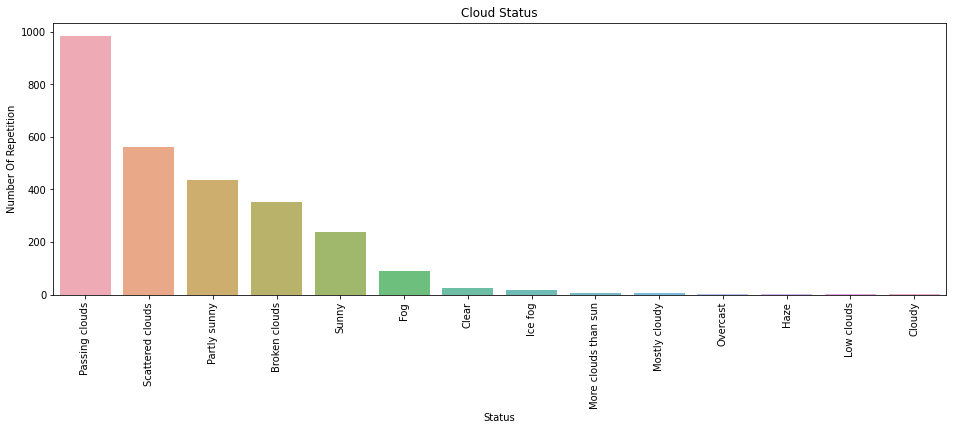

In [76]:
import seaborn as sns
weather_counts = average_weather['cloud'].value_counts()
plt.figure(figsize=(16,5))
sns.barplot(weather_counts.index, weather_counts.values, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Cloud Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

/home/nhat/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


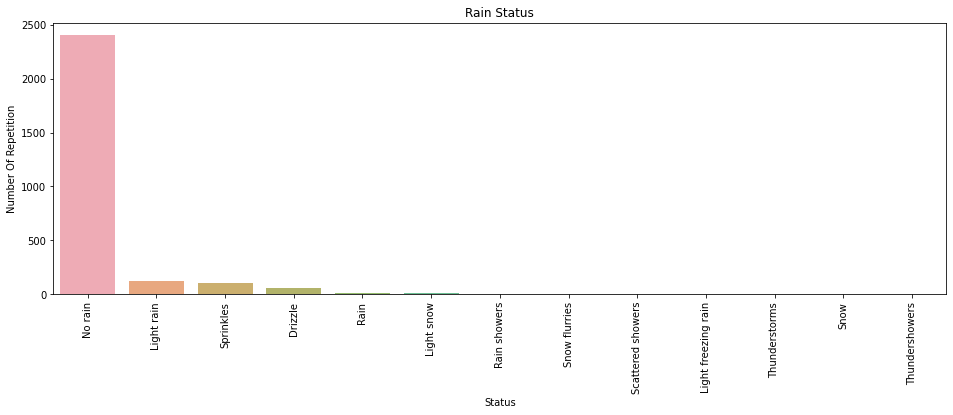

In [77]:
rain_counts = average_weather['rain'].value_counts()
plt.figure(figsize=(16,5))
sns.barplot(rain_counts.index, rain_counts.values, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Rain Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

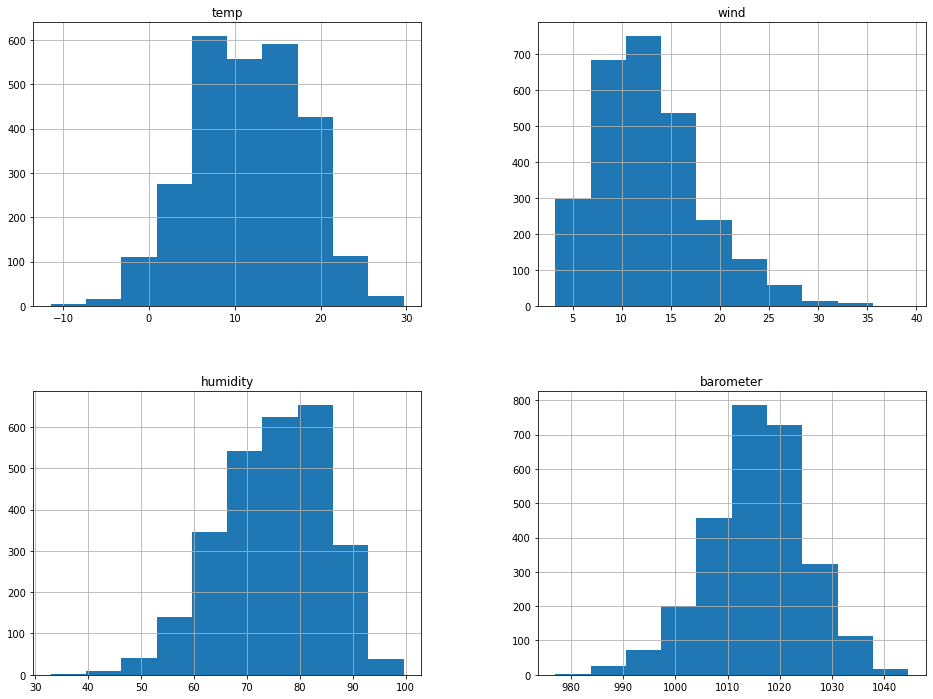

In [78]:
average_weather.hist(figsize=(16,12))
plt.show()

At this step, the weather dataset is ready to be used. In fact, the NaN values are still there, but the way in which they are treated will affect the outcome of the model. Therefore, it is better to deal with them later, during the training step.

In [102]:
energy = pd.read_csv(path/'PV_Elec_Gas3.csv', delimiter=',', engine='python',
                     header=0)

In [103]:
energy.head()

,date,Cumulative_solar_power,kWh electricity/day,Gas/day
0,26/10/2011,0.1,15.1,9.0
1,27/10/2011,10.2,7.4,9.2
2,28/10/2011,20.2,5.8,8.0
3,29/10/2011,29.6,4.9,6.6
4,30/10/2011,34.2,11.7,5.3


In [104]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3304 entries, 0 to 3303
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    3304 non-null   object 
 1   Cumulative_solar_power  3304 non-null   float64
 2   kWh electricity/day     3304 non-null   float64
 3   Gas/day                 3304 non-null   float64
dtypes: float64(3), object(1)
memory usage: 103.4+ KB


The first thing that we can see is that data has the object type. Pandas provide a date type:

In [105]:
average_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   temp       2726 non-null   float64       
 1   cloud      2731 non-null   object        
 2   rain       2731 non-null   object        
 3   wind       2718 non-null   float64       
 4   humidity   2708 non-null   float64       
 5   barometer  2726 non-null   float64       
 6   date       2731 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 149.5+ KB


So the first step is to convert the type of data column

In [106]:
energy.date = pd.to_datetime(energy.date)
energy.set_index(['date'], inplace=True)       #change the index
energy.head()

,Cumulative_solar_power,kWh electricity/day,Gas/day
date,,,
2011-10-26,0.1,15.1,9.0
2011-10-27,10.2,7.4,9.2
2011-10-28,20.2,5.8,8.0
2011-10-29,29.6,4.9,6.6
2011-10-30,34.2,11.7,5.3


What we care about is the amount of energy generated daily, so let drop other information.

In [107]:
energy.drop(labels='kWh electricity/day', axis=1, inplace=True)
energy.drop(labels='Gas/day', axis=1, inplace=True)
energy.rename(columns = {'Cumulative_solar_power':'cum_power'}, inplace = True)
energy.head()

,cum_power
date,
2011-10-26,0.1
2011-10-27,10.2
2011-10-28,20.2
2011-10-29,29.6
2011-10-30,34.2


We known from the description of the dataset that data is recorded at the beginning of the day. Hence the number actually describes the cum_power in the previous day.

In [108]:
energy = energy.shift(periods=-1, freq='D', axis=0) 

In [109]:
energy.head()

,cum_power
date,
2011-10-25,0.1
2011-10-26,10.2
2011-10-27,20.2
2011-10-28,29.6
2011-10-29,34.2


It is still not done yet. The number that we currently have is the cumulative number. What we really need is the daily number.

In [114]:
power_list = [0] * len(energy)
power_list[0] = energy['cum_power'][0]

for i in range(len(energy)-1):
    power_list[i+1] = energy['cum_power'][i+1] - energy['cum_power'][i]

energy.insert(1, "daily_power", power_list, True)
energy.drop(labels='cum_power', axis=1, inplace=True)

In [119]:
energy.head()

,daily_power
date,
2011-10-25,0.1
2011-10-26,10.1
2011-10-27,10.0
2011-10-28,9.4
2011-10-29,4.6


In [116]:
len(average_weather), len(energy)

(2731, 3304)

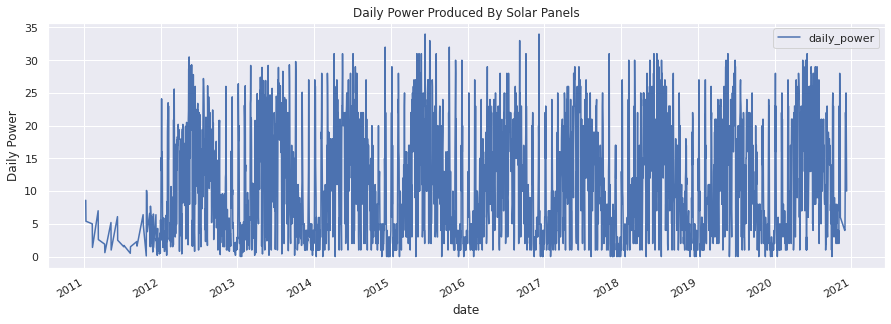

In [118]:
sns.set()
power_index= energy.reset_index()
power_index.plot(kind='line', x='date', y='daily_power', figsize=(15,5))

plt.title('Daily Power Produced By Solar Panels')
plt.ylabel('Daily Power')
plt.show()

In [120]:
def merge_weatherANDpower():
    dataset = average_weather.merge(energy, on=['date'])
    return dataset.set_index('date')

final_dataset = merge_weatherANDpower()
final_dataset.head()

,temp,cloud,rain,wind,humidity,barometer,daily_power
date,,,,,,,
2012-01-01,12.333333,Overcast,No rain,21.333333,89.333333,1007.866667,5.6
2012-01-02,7.787234,Scattered clouds,No rain,17.212766,81.425532,1009.170213,2.5
2012-01-03,8.208333,Fog,Light rain,32.354167,78.229167,1007.916667,7.6
2012-01-04,7.354167,Broken clouds,No rain,26.375000,71.041667,1012.687500,15.1
2012-01-05,8.292683,Broken clouds,Rain showers,39.170732,77.804878,998.219512,13.1


In [121]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2731 entries, 2012-01-01 to 2019-12-29
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp         2726 non-null   float64
 1   cloud        2731 non-null   object 
 2   rain         2731 non-null   object 
 3   wind         2718 non-null   float64
 4   humidity     2708 non-null   float64
 5   barometer    2726 non-null   float64
 6   daily_power  2731 non-null   float64
dtypes: float64(5), object(2)
memory usage: 170.7+ KB
